In [139]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from math import pow
plt.style.use('ggplot')

np.random.seed(1)

# Problema

$-\frac{d^2u}{dx^2} = 2$

$u(0) = u(1) = 0$

Abrindo em série de taylor a função $u$ em torno do ponto $x_i$

$u(x) = u(x_i) + u^\prime(x)(x-x_i) +  \frac{1}{2!} u^{\prime\prime}(x)(x-x_i)^2 + O((x-x_i)^3)$

Substituindo $x$ por $x_{i+1}$ e $x_{i-1}$ 

$u(x_{i+1}) = u(x_i) + u^\prime(x_i)h +  \frac{1}{2!} u^{\prime\prime}(x_i)h^2 + O(h^3)$

$u(x_{i-1}) = u(x_i) - u^\prime(x_i)h +  \frac{1}{2!} u^{\prime\prime}(x_i)h^2 + O(h^3)$

Subtraindo as duas equações e rearranjando

$ u^{\prime\prime}(x_i)  = \frac{u(x_{i+1}) + u(x_{i-1}) - 2u(x_i)}{h^2} $

## Entrada

In [140]:
N = 2**12 - 1 #quantidade de pontos

In [141]:

u0 = 2*(np.random.rand(N+2) - 0.5)
u0[0] = 0; u0[-1] = 0;

u     = np.copy(u0)
u_ant = np.copy(u0)

x = np.linspace(0.0, 1.0, num=N+2, endpoint=True)

h = 1.0/(N+1)

f   = lambda x: 2
sol = lambda x: x*(1-x)

f_vec = np.array([f(i) for i in x])
sol_vec = np.apply_along_axis(sol, 0, np.copy(x))

resultados = {}

In [142]:
print len(x), len(u), len(f_vec)

4097 4097 4097


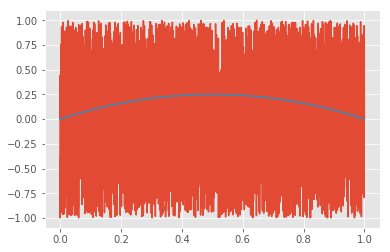

In [143]:
plt.plot(x, u)
plt.plot(x,sol_vec)

In [144]:
def GS(u, f):
    for i in range(1, len(u) - 1):
        u[i] = 0.5*(h*h*f(i*h) + u[i-1] + u[i+1])

def GS_Vetor(u, r):
    h = 1.0/(len(u)-1)
    for i in range(1, len(u) - 1):
        u[i] = 0.5*(h*h*r[i] + u[i-1] + u[i+1])
        
def Jacobi(u, u_ant, f):
    for i in range(1, len(u) - 1):
        u[i] = 0.5*(h*h*f(i*h) + u_ant[i-1] + u_ant[i+1])    

# Gauss Seidel

In [145]:
erro = 1
iteracoes = 0

while erro > 1e-6 and iteracoes < 2e4:
    GS_Vetor(u,f_vec)
    erro = np.linalg.norm(u-sol_vec)
    iteracoes += 1

print "Numero de iteracoes = %d\tErro = %e" % (iteracoes, erro)

resultados["Gauss Seidel"] = (iteracoes, erro)

Numero de iteracoes = 20000	Erro = 1.156884e+01


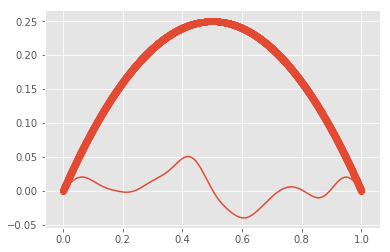

In [146]:
plt.plot(x,u)
plt.scatter(x,sol_vec)

# Jacobi

In [147]:
erro = 1
iteracoes = 0
while erro > 1e-6  and iteracoes < 2e4:
    Jacobi(u,u_ant,f)
    Jacobi(u_ant, u, f)
    erro = np.linalg.norm(u_ant-sol_vec)
    iteracoes += 2

print "Numero de iteracoes = %d\tErro = %e" % (iteracoes, erro)

resultados["Jacobi"] = (iteracoes, erro)

Numero de iteracoes = 20000	Erro = 1.179911e+01


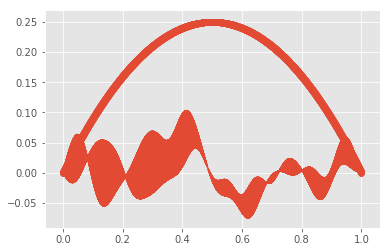

In [148]:
plt.plot(x,u_ant)
plt.scatter(x,sol_vec)

# Multigrid

## Operador de Restrição

In [149]:
def R(u):
    ubarra = np.zeros((len(u)-1)/2 + 1)
    
    for i in xrange(1, len(ubarra) - 1):
        ubarra[i] = 0.5*u[2*i]+0.25*u[2*i-1]+0.25*u[2*i+1]
    return ubarra

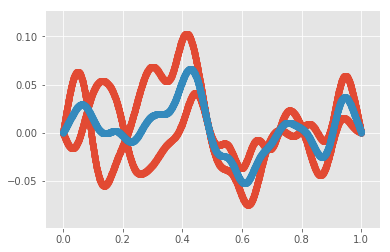

In [150]:
ubarra = R(u_ant)
hbarra = 1.0/(len(ubarra)-1)
x = np.linspace(0.0, 1.0, num=len(u), endpoint=True)
xbarra = np.linspace(0.0, 1.0, num=len(ubarra), endpoint=True)

plt.scatter(x, u_ant)
plt.scatter(xbarra, ubarra)

## Operador de Prolongamento

In [151]:
def P(ubarra):
    u = np.zeros(2*(len(ubarra)-1) + 1)
    for i in xrange(len(u)):
        if i%2 == 0:
            u[i] = ubarra[i/2]
        else:
            u[i] = 0.5*(ubarra[i/2] + ubarra[i/2+1])
    
    return u

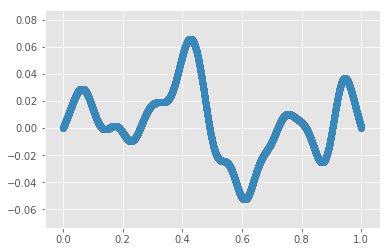

In [152]:
u = P(ubarra)
x = np.linspace(0.0, 1.0, num=len(u), endpoint=True)
xbarra = np.linspace(0.0, 1.0, num=len(ubarra), endpoint=True)

plt.scatter(x, u)
plt.scatter(xbarra, ubarra)

## Two-grid method

In [153]:
v1 = 2
v2 = 2

In [154]:
def residuo(u, f_vec, r):
    r[0]=r[-1]=0.0
    h = 1.0/(len(r)-1)
    for i in xrange(1, len(r)-1):
        r[i] = f_vec[i] + (u[i+1]+u[i-1]-2*u[i])/(h*h)
    

In [155]:
def operador(N):
    h = 1.0/(N+1)
    A = np.zeros((N, N))
    for i in range(N):
        A[i][i] = 2.0/(h*h)
        if i > 0: 
            A[i][i-1] = -1.0/(h*h)
        if i < N-1:
            A[i][i+1] = -1.0/(h*h)
    return A

def prox_tamanho(N):
    return (N+1)/2 - 1

In [156]:
u = np.copy(u0)
r = np.zeros(len(u))
Ah = operador(N)
A2h = operador(prox_tamanho(N))


erro = np.linalg.norm(u-sol_vec)

print "erro inicial %f" % erro
iteracoes = 0

cont_l1 = 0
cont_l2 = 0

while erro > 1e-6 and cont_l1 < 20000:

        
    for i in range(v1):
        GS(u, f)
        
    residuo(u, f_vec, r)
    
    r[1:-1] = f_vec[1:-1] - np.dot(Ah, u[1:-1])
   
    rbarra = R(r)
    ebarra = np.zeros(len(rbarra))
        
    ebarra[1:-1] = np.linalg.solve(A2h, rbarra[1:-1])

    u = u + P(ebarra)
    
    for i in range(v2):
        GS(u, f)
    
    erro = np.linalg.norm(u-sol_vec)

    cont_l1 += 1

iteracoes = cont_l1*(v1 + v2)
    
print "Numero de iteracoes = %d\tErro = %e" % (iteracoes, erro)
resultados["Two Grid"] = (iteracoes, erro)        

erro inicial 38.657300
Numero de iteracoes = 20	Erro = 2.569835e-07


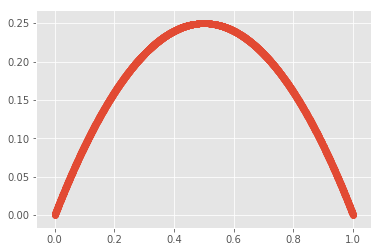

In [157]:
plt.plot(x,u)
plt.scatter(x,sol_vec)

## n-grid method

In [158]:
def n_grid_method(u, qtd_operadores = 5):
    u      = np.copy(u0)
    ubarra = np.copy(u0)
    rbarra = f_vec
    erro = np.linalg.norm(u-sol_vec)
    print "erro inicial %f" % erro

    tamanhos = [N]
    for i in range(1, qtd_operadores):
        tamanhos.append(prox_tamanho(tamanhos[-1]))

    operadores = [operador(n) for n in tamanhos]
    chutes = [ubarra]

    for n in tamanhos[1:]:
        chutes.append(np.zeros(n+2))

    cont_l1 = 0

    while erro > 1e-6 and cont_l1 < 20000:

        fs = [f_vec]

        for nivel in range(len(tamanhos)-1):
            A = operadores[nivel]
            n = tamanhos[nivel]
            fh = fs[nivel]
            for i in range(v1):
                GS_Vetor(chutes[nivel], fs[nivel])
            f2h = np.zeros(tamanhos[nivel] + 2)
            f2h[1:-1] = fh[1:-1] - np.dot(A, chutes[nivel][1:-1])
            f2h = R(f2h)
            fs.append(f2h)


        A = operadores[-1]
        fcoarse = fs[-1]
        e = np.zeros(tamanhos[-1]+2)
        e[1:-1] = np.linalg.solve(A, fcoarse[1:-1])

        for nivel in range(len(tamanhos)-2,-1,-1):

            if nivel == len(tamanhos)-2:
                chutes[nivel] = chutes[nivel] + P(e)
            else:
                chutes[nivel] = chutes[nivel] + P(chutes[nivel+1])

            for i in range(v2):
                GS_Vetor(chutes[nivel], fs[nivel])


        erro = np.linalg.norm(chutes[0]-sol_vec)

        cont_l1 += 1


    iteracoes = cont_l1*(v1+v2)*(1-pow(0.5, qtd_operadores-1))*2
    u = chutes[0]
    return iteracoes, erro

for qtd_operadores in range(2, 7):
    iteracoes, erro = n_grid_method(u, qtd_operadores)
    print "Numero de iteracoes = %d\tErro = %e" % (iteracoes, erro)
    resultados["%d Grid"%qtd_operadores] = (iteracoes, erro)      

erro inicial 38.657300
Numero de iteracoes = 20	Erro = 2.569835e-07
erro inicial 38.657300
Numero de iteracoes = 54	Erro = 3.897919e-07
erro inicial 38.657300
Numero de iteracoes = 98	Erro = 4.546456e-07
erro inicial 38.657300
Numero de iteracoes = 165	Erro = 6.401298e-07
erro inicial 38.657300
Numero de iteracoes = 325	Erro = 8.654514e-07


[  0.00000000e+00   2.44140625e-04   4.88281250e-04 ...,   9.99511719e-01
   9.99755859e-01   1.00000000e+00]


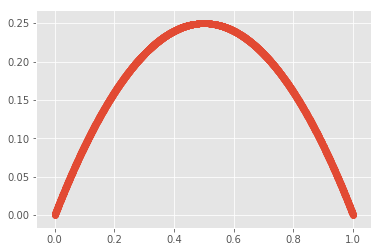

In [159]:
print x
plt.plot(x,u)
plt.scatter(x,sol_vec)

## Resultados

In [160]:
print "%-15s %-10s %-10s" %("Metodo", "Iteracoes", "Erro")
metodos = resultados.keys()
metodos.sort()
for m in metodos:
    print "%-15s %-10d %-10e" %(m, resultados[m][0], resultados[m][1])

Metodo          Iteracoes  Erro      
2 Grid          20         2.569835e-07
3 Grid          54         3.897919e-07
4 Grid          98         4.546456e-07
5 Grid          165        6.401298e-07
6 Grid          325        8.654514e-07
Gauss Seidel    20000      1.156884e+01
Jacobi          20000      1.179911e+01
Two Grid        20         2.569835e-07


# Frequencias da análise

O erro satisfaz a equação:



Abrindo o erro na série de fourier

$e^m_j = \sum_{\alpha=0}^{2n-1} c^m_j exp(ij\theta_\alpha)$ com $\theta_\alpha = \frac{\pi\alpha}{n}$ para $\alpha = 0,1,2,...,2n-1$

O período para um $\theta_\alpha$ é

$e^m_j = e^m_{j+T} \Rightarrow exp(ij\theta_\alpha) = exp(i(j + T)\theta_\alpha)$

$T\theta_\alpha = 2\pi \Rightarrow  T = \frac{2\pi}{\theta_\alpha}$

$T = \frac{2n}{\alpha}$

As altas frequências são aquelas com $T\le2 \Rightarrow \alpha \ge n$ De fato:

In [161]:
n = 4
h = 1.0/(2*n)
x = np.linspace(0.0, 1.0, num=2*n+1, endpoint=True)
x_n = np.linspace(0.0, 1.0, num=100, endpoint=True)

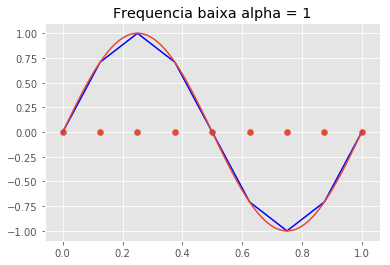

In [162]:
alpha = 1
plt.scatter(x, np.zeros(2*n+1))
plt.plot(x, np.sin(x*np.pi*alpha/(n*h)), c="b")
y = np.sin(x_n*np.pi*alpha/(n*h))
plt.plot(x_n,y)
plt.title("Frequencia baixa alpha = %d" %(alpha))

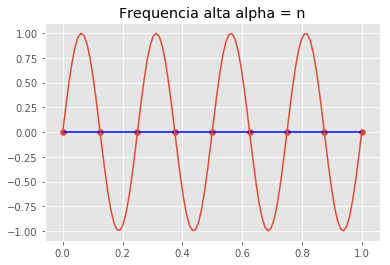

In [163]:
alpha = n
plt.scatter(x, np.zeros(2*n+1))
plt.plot(x, np.sin(x*np.pi*alpha/(n*h)), c="b")
y = np.sin(x_n*np.pi*alpha/(n*h))
plt.plot(x_n,y)
plt.title("Frequencia alta alpha = n")

alpha = 2*n-1
plt.scatter(x, np.zeros(2*n+1))
plt.plot(x, np.sin(x*np.pi*alpha/(n*h)), c="b")
y = np.sin(x_n*np.pi*alpha/(n*h))
plt.plot(x_n,y)
plt.title("Frequencia alta - alpha = 2n-1")

## Análise da convergência

$e^m_j = \sum_{\alpha=0}^{2n-1} c^m_j exp(ij\theta_\alpha)$

Iteração de Gauss-Seidel:

$-e^m_{j-1} + 2e^m_j = e^{m-1}_{j+1}$

Depois das contas:

$|g(\theta_\alpha)| = \frac{1}{\sqrt{5 - 4cos(\theta_\alpha)}}$

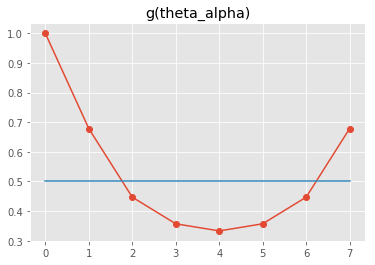

In [164]:
alpha = np.array(range(2*n))
theta = np.pi * alpha / float(n)
plt.plot(alpha, np.power(5.0 - 4.0*np.cos(theta), -0.5), marker="o")
plt.plot([0,2*n-1], [0.5, 0.5])
plt.title("g(theta_alpha)")
